<a href="https://colab.research.google.com/github/mhaseebk97/twitter/blob/main/twitter_hate_speech_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install --upgrade --force-reinstall numpy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 962.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting 

In [1]:
import pandas as pd
import google.colab.files as files
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import string
import warnings
import re
from gensim.models import Word2Vec
import numpy as np

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def data_review(df):
  print('Review the samples of the data.')
  print(df.sample(7))
  print('*'*100)
  print()
  print(f'Shape of the data: {df.shape}')
  print('*'*100)
  print()
  for column in df.columns:
    if (column == 'id') or (column == 'text '):
      continue
    print(f'Unique values in {column}: {df[column].unique()}')
  print('*'*100)
  print()
  count_0_hs = len(data[data['hs'] == 0])
  count_1_hs = len(data[data['hs'] == 1])
  count_0_st = len(data[data['stereotype'] == 0])
  count_1_st = len(data[data['stereotype'] == 1])
  print('*'*100)
  print()
  print(f"Count of 0's in the hs: {count_0_hs}")
  print(f"Count of 1's in the hs: {count_1_hs}")
  print('*'*100)
  print()
  print(f"Count of 0's in the stereotype: {count_0_st}")
  print(f"Count of 1's in the stereotype: {count_1_st}")
  print('*'*100)
  print()
  print(f'Count of duplicated values: {df.duplicated().sum()}')
  print('*'*100)
  print()
  print(f'Count of null values:')
  print(df.isnull().sum())
  print('*'*100)
  print()
  print('Reviw the data types of the columns.')
  print(df.info())

  return count_0_hs, count_1_hs, count_0_st, count_1_st

In [4]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [5]:
def fit_and_evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name):
    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Print the classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Overall Accuracy: {accuracy:.2f}\n")

In [6]:
class EmojiRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(remove_emoji)

In [7]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"   # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"   # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"   # Flags
        "\U0001F700-\U0001F77F"   # Alchemical Symbols
        "\U0001F780-\U0001F7FF"   # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"   # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"   # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"   # Chess Symbols
        "\U0001FA70-\U0001FAFF"   # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"   # Dingbats
        "\U000024C2-\U0001F251"   # Enclosed Characters
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)


In [8]:
# Define Text Preprocessor
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words):
        self.stop_words = stop_words

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Preprocess each document: lowercase, remove stopwords, keep only words
        return X.apply(lambda text: ' '.join(
            word for word in re.findall(r'\b[a-zA-Z]+\b', text.lower())
            if word not in self.stop_words
        ))

# Define Word2Vec Transformer
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.w2v_model = None

    def fit(self, X, y=None):
        # Train Word2Vec model on the corpus
        sentences = [text.split() for text in X]  # Tokenize each document
        self.w2v_model = Word2Vec(sentences, vector_size=self.vector_size,
                                  window=self.window, min_count=self.min_count)
        return self

    def transform(self, X):
        # Transform each document to the average of its word vectors
        def document_vector(doc):
            words = doc.split()
            # Filter out words not in the vocabulary
            words = [word for word in words if word in self.w2v_model.wv]
            if len(words) == 0:
                return np.zeros(self.vector_size)  # Handle empty docs
            return np.mean(self.w2v_model.wv[words], axis=0)

        return np.vstack([document_vector(doc) for doc in X])

In [28]:
filename = files.upload()

Saving haspeede2_dev_taskAB.tsv to haspeede2_dev_taskAB (2).tsv


Data

In [29]:
data = pd.read_csv('/content/haspeede2_dev_taskAB.tsv', sep='\t')
count_0_hs, count_1_hs, count_0_st, count_1_st = data_review(data)

Review the samples of the data.
        id                                              text   hs  stereotype
3719  1756  @user @user Ci lavorano solo islamici e comuni...   1           1
6502  8192  Due giovani turiste danese e norvegese #decapi...   1           1
882    643  #Roma, far west a #Corcolle: poliziotti aggred...   0           1
150   1493  @user scusa ma dovevo tacere sti stranieri che...   0           0
4291  9696  @user @user @user @user @user @user @user @use...   1           1
769    437  Roma, la cassiera è complice: nomadi fanno spe...   0           1
296   2606  Che bello sentire Alberto @user a #Roma parlar...   0           0
****************************************************************************************************

Shape of the data: (6837, 4)
****************************************************************************************************

Unique values in hs: [0 1]
Unique values in stereotype: [0 1]
*************************************************

In [30]:
data = data.rename(columns={'text ': 'text'})

In [12]:
# Tokenize the 'text' column
data['tokens'] = data['text'].apply(word_tokenize)
data.head()

,id,text,hs,stereotype,tokens
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0,"[È, terrorismo, anche, questo, ,, per, mettere..."
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0,"[@, user, @, user, infatti, finché, ci, hanno,..."
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0,"[Corriere, :, Tangenti, ,, Mafia, Capitale, di..."
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0,"[@, user, ad, uno, ad, uno, ,, perché, quando,..."
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0,"[Il, divertimento, del, giorno, ?, Trovare, i,..."


Count of unique tokens

In [13]:
# Combine all tokens into a single list
all_tokens = [token for sublist in data['tokens'] for token in sublist]
freq_dist = FreqDist(all_tokens)

print(f'Count of unique tokens: {len(all_tokens)}\n')
print("Ten Most Common Tokens:")
freq_dist.most_common(10)

Count of unique tokens: 194373

Ten Most Common Tokens:


[(',', 5992),
 ('#', 5018),
 ('@', 4727),
 ('user', 4712),
 ('.', 4473),
 ('di', 3949),
 ('e', 3848),
 ('URL', 3515),
 ('che', 2807),
 ('a', 2554)]

In [14]:
# Load stopwords and punctuation
stop_words = set(stopwords.words('italian'))
punctuation = set(string.punctuation)
punctuation.add('``')
punctuation.add('\'\'')
punctuation.add('...')
punctuation.add('’')

# Filter out stopwords and punctuation and convert filtered tokens to lower case
filtered_tokens = [token.lower() for token in all_tokens if token.lower() not in stop_words and token not in punctuation]
freq_dist_updated = FreqDist(filtered_tokens)

print(f'Count of unique filtered tokens: {len(filtered_tokens)}\n')
print("Ten Most Common Filtered Tokens:")
freq_dist_updated.most_common(10)

Count of unique filtered tokens: 100552

Ten Most Common Filtered Tokens:


[('user', 4712),
 ('url', 3515),
 ('rom', 1558),
 ('migranti', 1293),
 ('immigrati', 980),
 ('italia', 726),
 ('roma', 617),
 ('italiani', 599),
 ('stranieri', 454),
 ('solo', 415)]

Frequency Distribution

[Text(0, 0, 'user'),
 Text(1, 0, 'url'),
 Text(2, 0, 'rom'),
 Text(3, 0, 'migranti'),
 Text(4, 0, 'immigrati'),
 Text(5, 0, 'italia'),
 Text(6, 0, 'roma'),
 Text(7, 0, 'italiani'),
 Text(8, 0, 'stranieri'),
 Text(9, 0, 'solo')]

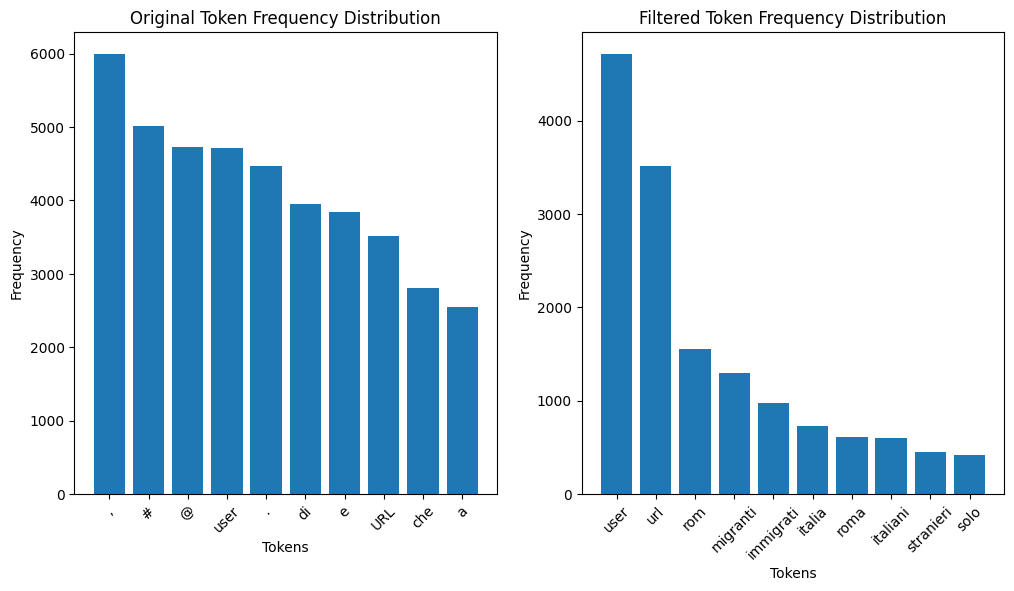

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].bar(*zip(*freq_dist.most_common(10)))
axes[0].set_title('Original Token Frequency Distribution')
axes[0].set_xlabel('Tokens')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels([token for token, _ in freq_dist.most_common(10)], rotation=45)

axes[1].bar(*zip(*freq_dist_updated.most_common(10)))
axes[1].set_title('Filtered Token Frequency Distribution')
axes[1].set_xlabel('Tokens')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels([token for token, _ in freq_dist_updated.most_common(10)], rotation=45)

In [16]:
# Extract bigrams and trigrams from the filtered tokens
bigrams = list(ngrams(filtered_tokens, 2))
trigrams = list(ngrams(filtered_tokens, 3))

# Create a frequency distributions of the bigrams and trigrams
bigram_freq_dist = FreqDist(bigrams)
trigram_freq_dist = FreqDist(trigrams)

print("Ten Most Common Bigrams:")
bigram_freq_dist.most_common(10)

Ten Most Common Bigrams:


[(('user', 'user'), 2073),
 (('url', 'user'), 791),
 (('url', 'url'), 242),
 (('campo', 'rom'), 189),
 (('url', 'roma'), 171),
 (('campi', 'rom'), 148),
 (('via', 'user'), 124),
 (('url', 'via'), 121),
 (('user', 'url'), 103),
 (('rom', 'url'), 98)]

In [17]:
print("Ten Most Common Trigrams:")
trigram_freq_dist.most_common(10)

Ten Most Common Trigrams:


[(('user', 'user', 'user'), 1059),
 (('url', 'user', 'user'), 338),
 (('url', 'via', 'user'), 109),
 (('url', 'url', 'user'), 59),
 (('via', 'user', 'user'), 35),
 (('user', 'user', 'url'), 34),
 (('user', 'url', 'user'), 29),
 (('studentessa', 'cinese', 'morta'), 25),
 (('cinese', 'morta', 'roma'), 20),
 (('--', '--', '--'), 20)]

In [18]:
data.drop(columns=['tokens'], inplace=True)

In [19]:
X = data['text']
y = data['hs']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
stop_words = list(stop_words)

pipeline_lr = Pipeline([
    ('emoji_remover', EmojiRemover()),
    ('tfidf', CountVectorizer(
        lowercase=True,
        stop_words=stop_words,
        token_pattern=r'\b[a-zA-Z]+\b',  # Only select alphabetic words
        binary=True,  # Replaces non-zero frequency with 1
        max_features=10000
    )),
    ('classifier', LogisticRegression())
])

pipeline_nb = Pipeline([
    ('emoji_remover', EmojiRemover()),
    ('tfidf', CountVectorizer(
        lowercase=True,
        stop_words=stop_words,
        token_pattern=r'\b[a-zA-Z]+\b',
        binary=True,
        max_features=10000
    )),
    ('classifier', MultinomialNB())
])

pipeline_lr_wb = Pipeline([
    ('emoji_remover', EmojiRemover()),
    ('tfidf', CountVectorizer(
        lowercase=True,
        stop_words=stop_words,
        token_pattern=r'\b[a-zA-Z]+\b',
        binary=True,
        max_features=10000
    )),
    ('classifier', LogisticRegression(class_weight='balanced'))
])


class_priors = [len(y_train[y_train == 0]) / len(y_train),
                len(y_train[y_train == 1]) / len(y_train)]

pipeline_nb_cp = Pipeline([
    ('emoji_remover', EmojiRemover()),
    ('tfidf', CountVectorizer(
        lowercase=True,
        stop_words=stop_words,
        token_pattern=r'\b[a-zA-Z]+\b',
        binary=True,
        max_features=10000
    )),
    ('classifier', MultinomialNB(class_prior=class_priors))
])

In [21]:
fit_and_evaluate_model(pipeline_lr, X_train, y_train, X_test, y_test, 'Logistic Regression')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          No       0.79      0.82      0.80       818
         Yes       0.71      0.67      0.69       550

    accuracy                           0.76      1368
   macro avg       0.75      0.74      0.75      1368
weighted avg       0.76      0.76      0.76      1368

Logistic Regression Overall Accuracy: 0.76



In [22]:
fit_and_evaluate_model(pipeline_nb, X_train, y_train, X_test, y_test, 'Naive Bayes')

Naive Bayes Classification Report:
              precision    recall  f1-score   support

          No       0.82      0.74      0.78       818
         Yes       0.67      0.76      0.71       550

    accuracy                           0.75      1368
   macro avg       0.74      0.75      0.74      1368
weighted avg       0.76      0.75      0.75      1368

Naive Bayes Overall Accuracy: 0.75



In [23]:
fit_and_evaluate_model(pipeline_lr_wb, X_train, y_train, X_test, y_test, 'Logistic Regression with Weighted Balance')

Logistic Regression with Weighted Balance Classification Report:
              precision    recall  f1-score   support

          No       0.80      0.78      0.79       818
         Yes       0.69      0.71      0.70       550

    accuracy                           0.75      1368
   macro avg       0.74      0.74      0.74      1368
weighted avg       0.75      0.75      0.75      1368

Logistic Regression with Weighted Balance Overall Accuracy: 0.75



In [24]:
fit_and_evaluate_model(pipeline_nb_cp, X_train, y_train, X_test, y_test, 'Naive Bayes with Class Priors')

Naive Bayes with Class Priors Classification Report:
              precision    recall  f1-score   support

          No       0.82      0.74      0.78       818
         Yes       0.67      0.76      0.71       550

    accuracy                           0.75      1368
   macro avg       0.74      0.75      0.74      1368
weighted avg       0.76      0.75      0.75      1368

Naive Bayes with Class Priors Overall Accuracy: 0.75



In [26]:
fit_and_evaluate_model(pipeline_lr, X_train, y_train, X_test, y_test, 'Logistic Regression')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          No       0.60      0.96      0.74       818
         Yes       0.51      0.07      0.12       550

    accuracy                           0.60      1368
   macro avg       0.56      0.51      0.43      1368
weighted avg       0.57      0.60      0.49      1368

Logistic Regression Overall Accuracy: 0.60



In [27]:
fit_and_evaluate_model(pipeline_nb, X_train, y_train, X_test, y_test, 'Naive Bayes')

Naive Bayes Classification Report:
              precision    recall  f1-score   support

          No       0.66      0.52      0.58       818
         Yes       0.46      0.60      0.52       550

    accuracy                           0.55      1368
   macro avg       0.56      0.56      0.55      1368
weighted avg       0.58      0.55      0.56      1368

Naive Bayes Overall Accuracy: 0.55

